In [158]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN

np.random.seed(0)

data preparation

In [159]:
def prepare_data_for_regression(df, drop_columns=[]):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = df.drop(columns=drop_columns)

    return df

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
    return make_scorer(rmse, greater_is_better=False)

initial_drop_columns = [
        'address',
        'title',
        'listing_id',
        'property_name',
        'available_unit_types',
        'property_details_url',
        'elevation',
        'tenure',
        'property_type',
        'floor_level',
        'furnishing',
        # remove 
        'subzone'
    ] + [
    #'subzone',
    #'planning_area',
    #'region',
    'lat',
    'lng',
    'floor_level_ground',
    'floor_level_high',
    'floor_level_low',
    'floor_level_mid',
    'floor_level_penthouse',
    'floor_level_top',
    'furnishing_partial',
    'furnishing_unfurnished',
    'furnishing_unspecified',
    'line_cc',
    'line_ce',
    'line_cg',
    'line_dt',
    'line_ew',
    'line_ne',
    'line_ns',
    'line_te',
    'gep_pri_sch_within_1km',
    'gep_pri_sch_within_1km_2km',
    'cc_type_CR',
    'cc_type_IEBP',
    'cc_type_IHL',
    'area_size', 
    'population'
]

In [160]:
df = pd.read_csv('../data/train.csv')
df = preprocess(df.copy())
df = prepare_data_for_regression(df, drop_columns=initial_drop_columns)

df_train, df_valid = train_test_split(df, test_size=0.30)

In [161]:
all_columns = [x for x in df_train.columns if x != 'price']

ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "planning_area"]), 
    remainder='passthrough'
)

pipe = Pipeline(
    [
        ('col_tranform', ct),
        # ('standard_scaler', StandardScaler()),
        # ('knn', KNNImputer())
    ]
)

In [162]:
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

X_valid = df_valid.drop('price', axis=1)
y_valid = df_valid['price']

In [163]:
t_X_train = pd.DataFrame(data=pipe.fit_transform(X_train), columns=pipe.get_feature_names_out())
t_X_valid = pd.DataFrame(data=pipe.transform(X_valid), columns=pipe.get_feature_names_out())

SHAP discussion

In [166]:
import shap 

In [167]:
# scaler =  StandardScaler()
model = xgb.XGBRegressor(
    max_depth = 20, 
    n_estimators = 100, 
    min_child_weight = 5, 
    learning_rate = 0.05
)
# model = xgb.XGBRegressor(
#     max_depth = search.best_params_['xgb__max_depth'], 
#     n_estimators = search.best_params_['xgb__n_estimators'], 
#     min_child_weight = search.best_params_['xgb__min_child_weight'], 
#     learning_rate = search.best_params_['xgb__learning_rate']
# )

shap_df_train = t_X_train.copy()

model.fit(shap_df_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [168]:
y_pred = model.predict(shap_df_train)
se = (np.array(y_train).reshape(-1, 1) - np.array(y_pred).reshape(-1, 1)) ** 2
np.argmax(se), se[np.argmax(se)], np.argmin(se), se[np.argmin(se)]

(9672, array([2.07183724e+14]), 11773, array([17.015625]))

summary plot

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


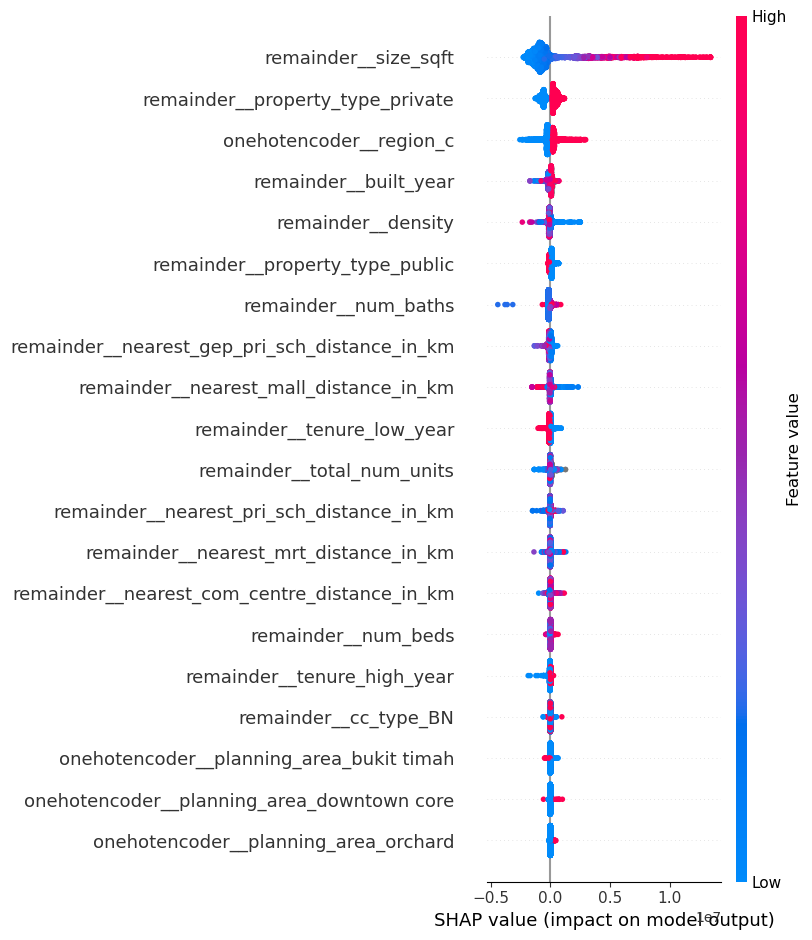

In [169]:
# use a random sample of dataset due to resource limitations
shap_df_train_sample = shap_df_train.copy()

l = [np.argmin(se), np.argmax(se)]
l.extend(range(5000))
shap_df_train_sample = shap_df_train_sample.iloc[l]
# X_train_sample =  X_train[:1000] + + shap_df_train_sample[np.argmax(se)] + shap_df_train_sample[np.argmin(se)]

# cannot fit pipeline model 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_df_train_sample)

shap.summary_plot(shap_values, shap_df_train_sample)

waterfall plot

In [226]:
print('prediction with lowest RMSE')
print('actual:', y_train.iloc[np.argmin(se)])
print('predicted:', y_pred[np.argmin(se)])

actual: 514500.0
predicted: 514504.12


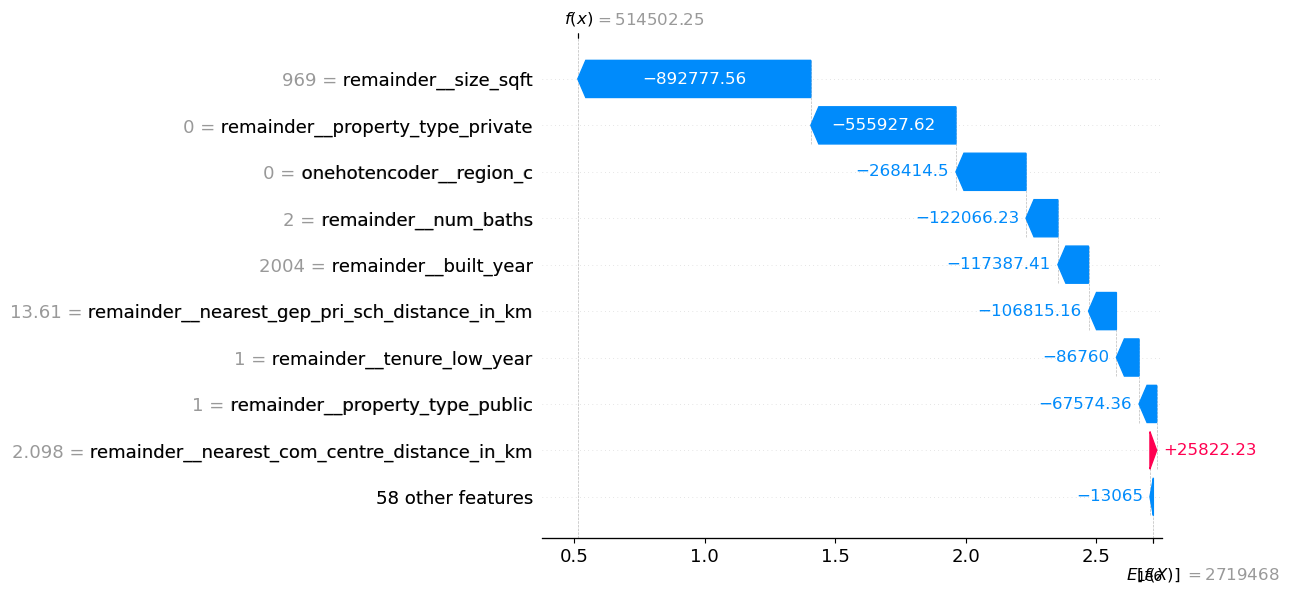

In [170]:
# visualize the first prediction's explanation
shap.plots.waterfall(explainer(shap_df_train_sample)[0])

In [228]:
print('prediction with highest RMSE')
print('actual:', y_train.iloc[np.argmax(se)])
print('predicted:', y_pred[np.argmax(se)])


prediction with highest RMSE
actual: 16884000.0
predicted: 2490122.0


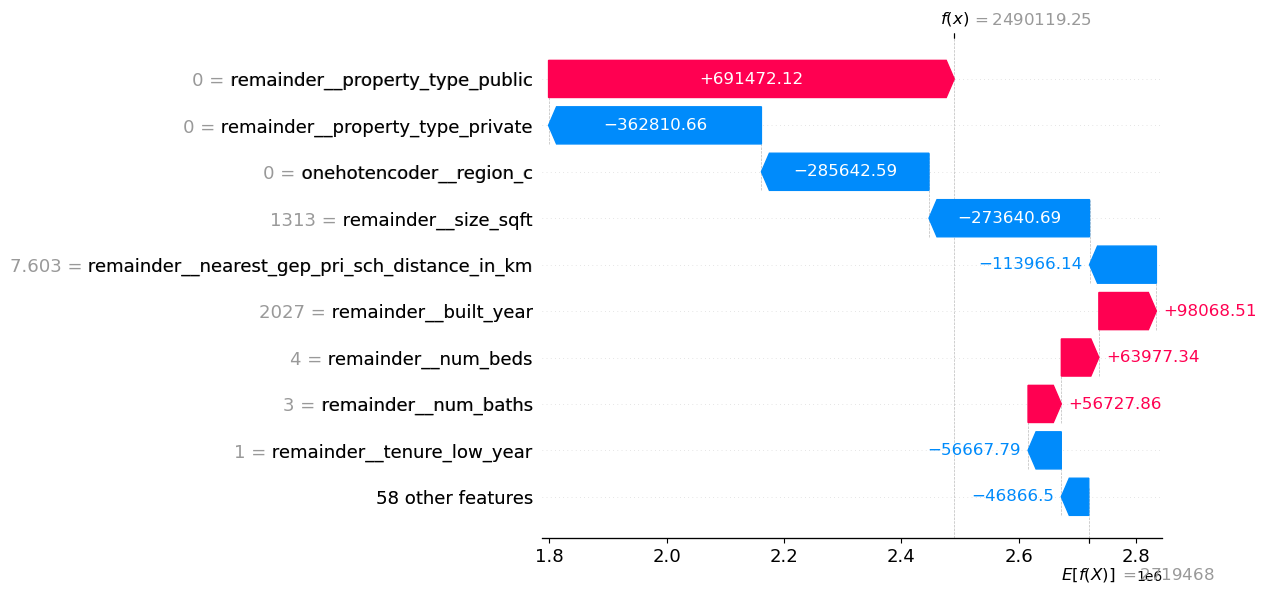

In [171]:
# visualize the first prediction's explanation
shap.plots.waterfall(explainer(shap_df_train_sample)[1])

dependence plot

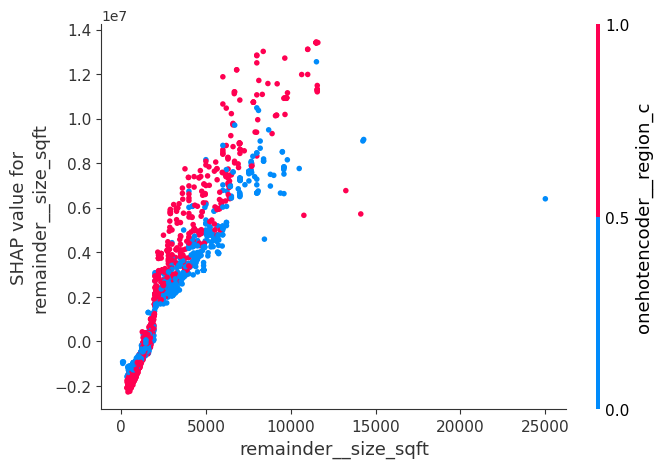

In [173]:
shap.dependence_plot("remainder__size_sqft", shap_values, shap_df_train_sample)

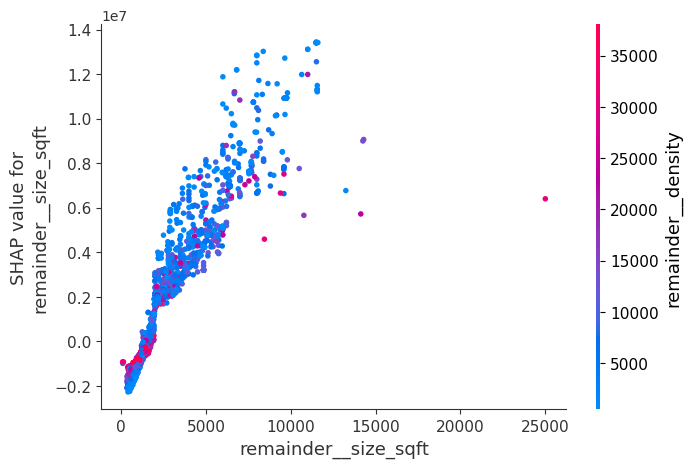

In [196]:
shap.dependence_plot("remainder__size_sqft", shap_values, shap_df_train_sample, interaction_index="remainder__density")

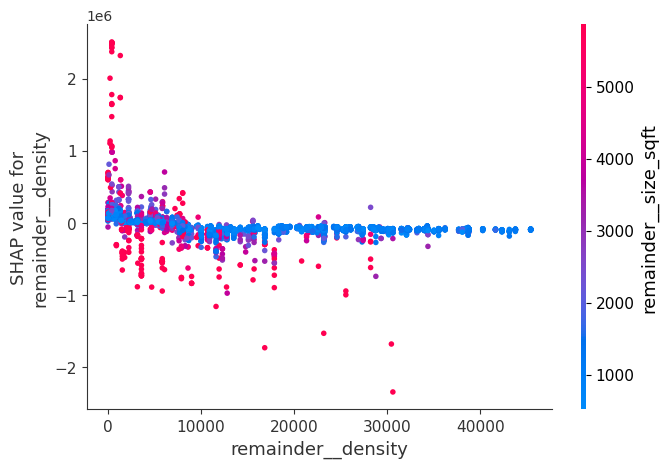

In [181]:
shap.dependence_plot("remainder__density", shap_values, shap_df_train_sample)

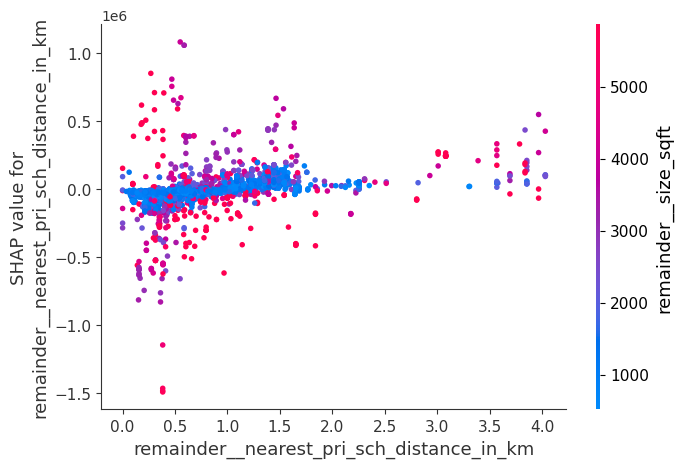

In [182]:
shap.dependence_plot("remainder__nearest_pri_sch_distance_in_km", shap_values, shap_df_train_sample)

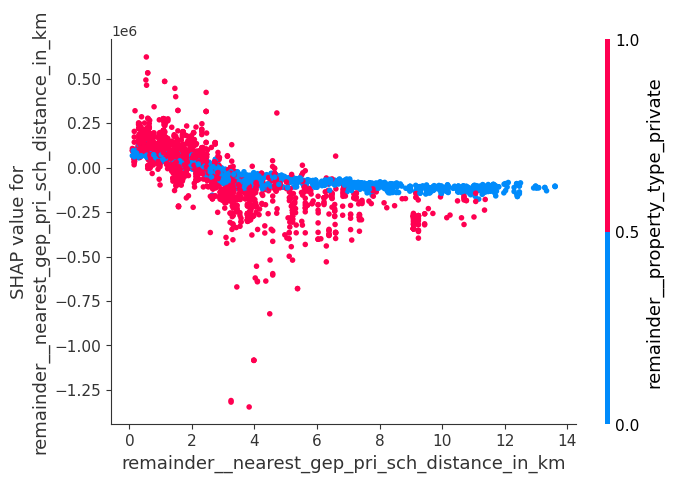

In [183]:
shap.dependence_plot("remainder__nearest_gep_pri_sch_distance_in_km", shap_values, shap_df_train_sample)

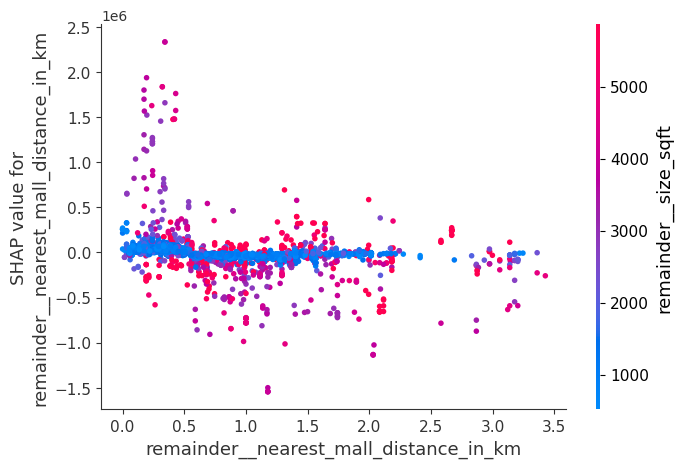

In [184]:
shap.dependence_plot("remainder__nearest_mall_distance_in_km", shap_values, shap_df_train_sample)

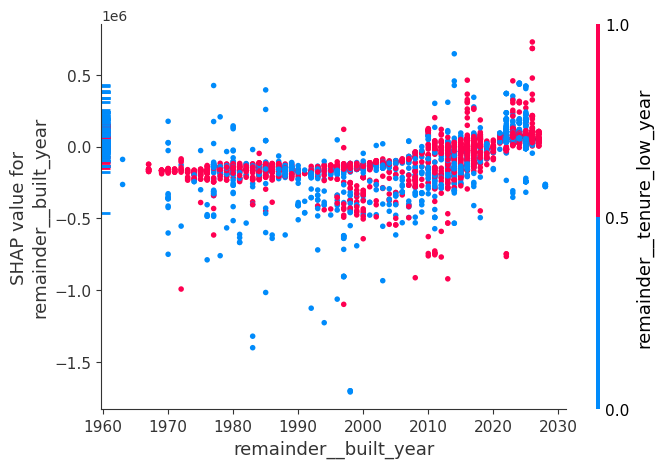

In [213]:
shap.dependence_plot(
    "remainder__built_year", 
    shap_values, 
    shap_df_train_sample, 
    interaction_index="remainder__tenure_low_year"
)

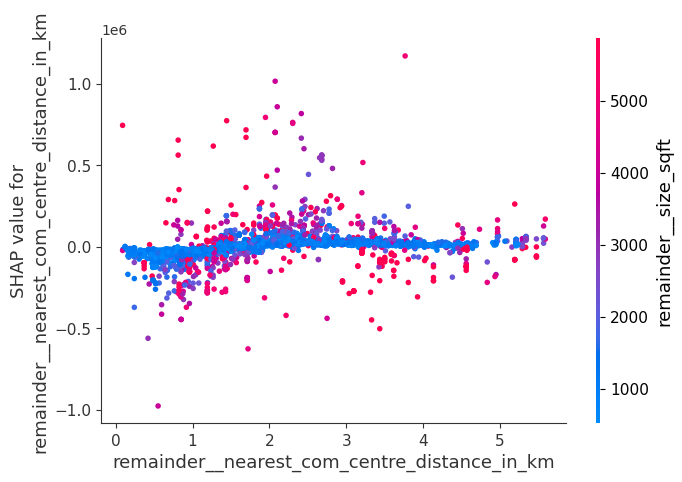

In [186]:
shap.dependence_plot("remainder__nearest_com_centre_distance_in_km", shap_values, shap_df_train_sample)

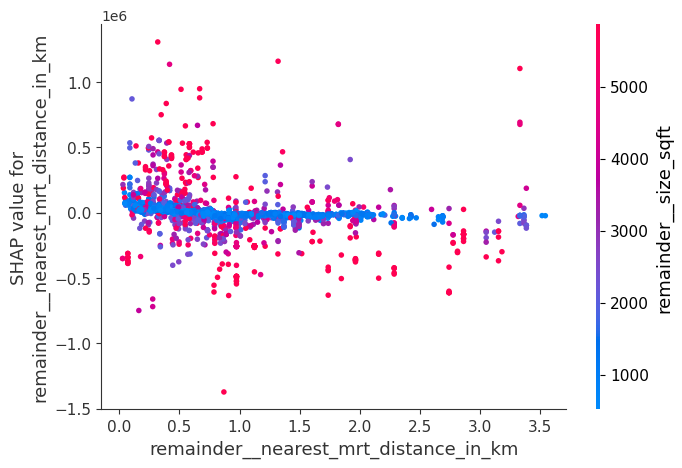

In [214]:
shap.dependence_plot(
    "remainder__nearest_mrt_distance_in_km", 
    shap_values, 
    shap_df_train_sample
)